# Proyecto
## Clasificación de Sonidos Urbanos

**Universidad del Valle de Guatemala**\
**Facultad de Ingeniería**\
**Departamento de Ciencias de la Computación**\
**Deep Learning**

---
### Integrantes:
- Diego Leiva
- Pablo Orellana
- Maria Marta Ramirez
---

## Librerias

In [ ]:
# Datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut

# Torch
import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Utils
import os
from tqdm import tqdm
import random
import platform

# Advertencias
import warnings
warnings.filterwarnings("ignore") # Ignorar advertencias

## Metadatos

In [114]:
AUDIO_PATH = 'data/UrbanSound8K/audio/'

# Obtencion de metadatos
metadata = pd.read_csv('data/UrbanSound8K/metadata/UrbanSound8K.csv')
files = metadata['slice_file_name'].values
labels = metadata['classID'].values
folds = metadata['fold'].values
classes = metadata['class'].values

# Creacion de directorios
paths = [
    os.path.join(AUDIO_PATH + f"fold{fold}", file) for fold, file in zip(folds, files)
]

# Crear y ordenar el diccionario de mapeo classID -> class
class_mapping = dict(sorted(metadata[['classID', 'class']].drop_duplicates().set_index('classID')['class'].to_dict().items()))

# Ver el mapeo resultante
print("-"*15, " Mapeo de clases ", "-"*15)
for key, value in class_mapping.items():
    print(f"{key}: {value}")


---------------  Mapeo de clases  ---------------
0: air_conditioner
1: car_horn
2: children_playing
3: dog_bark
4: drilling
5: engine_idling
6: gun_shot
7: jackhammer
8: siren
9: street_music


## Configuracion de PyTorch CUDA

In [115]:
# Semilla para reproducibilidad
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Configuración de determinismo
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_info = ""

# Configuración de dispositivo
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    device_info = f'{torch.cuda.get_device_name(0)}'
else:
    device_info = f"{platform.processor()}"

print(f"Device: {device_info}")

Device: NVIDIA GeForce RTX 3070 Ti Laptop GPU


## Dataset y Dataloader de Audio

In [ ]:
class AudioDataset():
    def __init__(self, paths, labels):
        self.paths = paths
        self.labels = labels
        self.audio_length = 160000  # 4 segundos de audio

        # Definir transformaciones con parámetros ajustados
        self.mel_spec = torchaudio.transforms.MelSpectrogram(
            sample_rate=22050,
            n_fft=2048,
            win_length=1024,
            hop_length=512,
            n_mels=120,  # Reducido de 128
            f_min=0,
            f_max=11025  # sample_rate/2
        )
        
        self.mfcc = torchaudio.transforms.MFCC(
            sample_rate=22050,
            n_mfcc=48
        )

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        file = self.paths[idx]
        waveform, _ = torchaudio.load(file, normalize=True)
        mono = torch.mean(waveform, dim=0, keepdim=True)

        temp = torch.zeros([1, self.audio_length])
        if mono.numel() < self.audio_length:
            temp[:, :mono.numel()] = mono
        else:
            temp = mono[:, :self.audio_length]

        # Asignar audio mono 
        audio_mono = temp

        # Obtener espectrograma de Mel
        mel_spectrogram = self.mel_spec(audio_mono)
        mel_spectrogram_norm = (mel_spectrogram - mel_spectrogram.mean()) / mel_spectrogram.std()

        # Obtener MFCC
        mfcc = self.mfcc(audio_mono)
        mfcc_norm = (mfcc - mfcc.mean()) / mfcc.std()

        # Ajustar el tamaño de MFCC para que coincida con el de Mel
        if mfcc_norm.size(2) != mel_spectrogram_norm.size(2):
            mfcc_norm = F.interpolate(mfcc_norm, size=mel_spectrogram_norm.size(2), mode='linear')

        # Crear el feature vector
        feature_vector = torch.cat([mel_spectrogram_norm, mfcc_norm], axis=1)

        feature_dict = {
            'feature_vector': feature_vector[0].permute(1, 0).clone().detach(),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }
        
        return feature_dict

In [ ]:
def collate_data(data):
    # Inicializar listas de features y labels
    features = []
    labels = []

    # Iterar sobre los datos
    for element in data:
        # Extraer feature y label
        feature = element["feature_vector"].to(device)
        label = element["label"].to(device)

        # Agregar a las listas
        features.append(feature)
        labels.append(label)

    # Realizar padding de los features y convertir labels a tensor
    feature = nn.utils.rnn.pad_sequence(features, batch_first=True, padding_value=0.)
    labels = torch.stack(labels).long()  # Asegurar que labels sea Long

    return feature, labels

## Modelo LSTM

In [ ]:
class AudioLSTM(nn.Module):
    def __init__(self, feature_size, out_features, hidden_layers, layers, dropout):
        super().__init__()
        self.n_hidden = hidden_layers
        self.n_layers = layers
        self.n_feature = feature_size

        # Capa LSTM
        self.lstm = nn.LSTM(
            input_size=self.n_feature,
            hidden_size=self.n_hidden,
            num_layers=self.n_layers,
            dropout=dropout,
            batch_first=True
        )

        # Capa de dropout
        self.dropout = nn.Dropout(dropout)

        # Activacion
        self.relu = nn.ReLU()

        # Capas lineales (fully connected)
        self.fc1 = nn.Linear(int(hidden_layers), int(hidden_layers/2))
        self.fc2 = nn.Linear(int(hidden_layers/2), out_features)


    # Forward pass
    def forward(self, x, hidden):
        # X shape -> (batch_size, sequence_length, n_features)
        l_out, l_hidden = self.lstm(x, hidden)

        # Out shape -> (batch_size, sequence_length, n_hidden*direcction)
        out = self.dropout(l_out)

        # out shape -> (batch_size, out_features)
        out = self.fc1(out) # Capa 1
        out = self.fc2(out[:, -1, :]) # Capa 2

        # Retornar el output y el hidden state
        return out, l_hidden
    

    # Inicializar hidden state
    def init_hidden(self, batch_size):
        # Obtener pesos de la primera capa
        weight = next(self.parameters()).data
        # Inicializar hidden state con ceros
        hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))
        # Retornar hidden state
        return hidden

In [ ]:
def save_model(state, path):
    torch.save(state, path)

### Loop de entrenamiento

In [ ]:
def train_model(data_loader, model, epoch, optimizer, device):
    # Inicializar lista de perdidas, accuracy, labels y predicciones
    losses = []
    labels = []
    predictions = []

    # Establecer modelo en modo de entrenamiento
    model.train()

    # Crear barra de progreso
    loop = tqdm(data_loader)

    # Iterar sobre los datos
    for batch_idx, (data, target) in enumerate(loop):
        # Enviar datos al dispositivo
        data = data.to(device)
        target = target.to(device)

        # Limpiar gradientes
        model.zero_grad()

        # Inicializar hidden state y output
        output, _ = model(data, model.init_hidden(data.size(0)))
        
        # Calcular perdida
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward() # Backpropagation

        # Optimizar
        optimizer.step()

        # Agregar perdida
        losses.append(loss.item())
        
        # Obtener mayor valor de output
        winners = output.argmax(dim=1)
        
        # Agregar labels y predicciones
        labels += torch.flatten(target).cpu().tolist()
        predictions += torch.flatten(winners).cpu().tolist()

        # Calcular accuracy del batch
        batch_accuracy = (winners == target).sum().float() / float(target.size(0))

        # Actualizar barra de progreso
        loop.set_description(f"TRAIN -> Epoch {epoch} | Batch: {batch_idx}/{len(data_loader)-1} | Loss: {loss.item():.4f} | Accuracy: {batch_accuracy:.4f}")

        # Early stopping for debugging
        if batch_idx == 5:
            break


    # Obtener promedio de perdidas y accuracy total del epoch
    total_loss = np.mean(losses)
    total_accuracy = np.mean(np.array(labels) == np.array(predictions))

    # Obterner reporte de clasificacion de la epoch
    train_report = classification_report(labels, predictions, output_dict=True)
    # Obtener matriz de confusion de la epoch
    train_confusion_matrix = confusion_matrix(labels, predictions)

    # Retornar perdida, accuracy, reporte y matriz de la epoca
    return total_loss, total_accuracy, train_confusion_matrix, train_report

### Loop de Validacion

In [ ]:
def validate(data_loader, model, device):
    # Inicializar lista de perdidas, accuracy, labels
    losses = []
    labels = []
    predictions = []
    
    # Configurar modelo en modo de evaluacion
    model.eval()

    # Sin actualizar gradientes
    with torch.no_grad():
        # Crear barra de progreso
        loop = tqdm(data_loader)

        # Iterar sobre los datos
        for batch_idx, (data, target) in enumerate(loop):
            # Enviar datos al dispositivo
            data = data.to(device)
            target = target.to(device)

            # Inicializar hidden state y output
            output, _ = model(data, model.init_hidden(data.size(0)))

            # Calcular perdida
            loss = nn.CrossEntropyLoss()(output, target)
            # Agregar perdida
            losses.append(loss.item())

            # Obtener mayor valor de output
            winners = output.argmax(dim=1)

            # Agregar lables y predicciones
            labels += torch.flatten(target).cpu()
            predictions += torch.flatten(winners).cpu()

            # Calcular accuracy
            batch_accuracy = (winners == target).sum().float() / float(target.size(0))

            loop.set_description(f"VALIDATE -> Batch: {batch_idx}/{len(data_loader)-1} | Accuracy: {batch_accuracy:.4f}")

            # Early stopping for debugging
            if batch_idx == 5:
                break

    # Calcular accuracy total de toda la época de validación
    total_accuracy = np.mean(np.array(labels) == np.array(predictions))
    # Obtener promedio de perdidas de la época de validación
    total_loss = np.mean(losses)

    # Obtener reporte de clasificación de la época de validación
    val_report = classification_report(labels, predictions, output_dict=True)
    # Obtener matriz de confusión de la época de validación
    val_confusion_matrix = confusion_matrix(labels, predictions)

    # Retornar perdida, accuracy, reporte y matriz de la época de validación
    return total_loss, total_accuracy, val_confusion_matrix, val_report


## Configuracion inicial

In [ ]:
# Constantes
EPOCHS = 2 # Numero de epocas
OUT_FEATURE = 10 # Numero de clases
PATIENCE = 5 # Paciencia para Early Stopping

## Loop Principal

En este loop se hacen los splits train-test para los 10 Folds, de esta manera se entrena el modelo con 9 Folds y se Valida con el Sobrante. Obteniendo metricas de rendimiento para la mejor epoca en cada Fold.

In [ ]:
# Leave One Group Out Cross Validation
logo = LeaveOneGroupOut()

# Lista de diccionarios de Rendimiento de cada fold
folds_performance = []

# Loop de entrenamiento por epocas y folds
for fold_idx, (train_idx, val_idx) in enumerate(logo.split(paths, labels, folds)):
    
    # Diccionario de resultados del fold actual
    results = {
        'fold': fold_idx + 1,
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': [],
        'train_report': None,
        'val_report': None,
        'train_matrix': None,
        'val_matrix': None,
        'best_accuracy': 0,
        'best_epoch': 0
    }

    # Imprimir separador si no es el primer fold
    if fold_idx > 0:
        print(f"\n")
    
    print("-"*15, f" FOLD {fold_idx+1} ", "-"*15)

    # Dividir datos en train y validation sets
    train_paths = [paths[i] for i in train_idx]
    val_paths = [paths[i] for i in val_idx]
    train_labels = [labels[i] for i in train_idx]
    val_labels = [labels[i] for i in val_idx]

    # Crear datasets
    train_dataset = AudioDataset(train_paths, train_labels)
    val_dataset = AudioDataset(val_paths, val_labels)

    # Crear dataloaders
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False, collate_fn=collate_data)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, collate_fn=collate_data)

    # Entrenamiento del Modelo
    model = AudioLSTM(feature_size=168, 
                      out_features=OUT_FEATURE, 
                      hidden_layers=256, 
                      layers=2, 
                      dropout=0.3).to(device)
    
    # Crear optimizador AdamW y scheduler
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=PATIENCE)

    # Loop de entrenamiento
    for epoch in range(EPOCHS):
        # Entrenar modelo y obtener perdidas y accuracy
        epoch_train_loss, epoch_train_acc, epoch_train_matrix, epoch_train_report = train_model(train_loader, model, epoch, optimizer, device)

        # Validar modelo y obtener accuracy
        epoch_val_loss, epoch_val_acc, epoch_val_matrix, epoch_val_report = validate(val_loader, model, device)

        # Guardar perdidas y accuracies del epoch actual
        results['train_losses'].append(epoch_train_loss)
        results['val_losses'].append(epoch_val_loss)
        results['train_accuracies'].append(epoch_train_acc)
        results['val_accuracies'].append(epoch_val_acc)
        
        # Actualizar el scheduler y guardar el mejor modelo
        scheduler.step(epoch_train_acc)
        
        # Guardar el mejor modelo y metricas de desempeño para el fold actual
        if epoch_val_acc > results['best_accuracy']:
            # Actualizar mejor accuracy y epoch
            results['best_accuracy'] = epoch_val_acc
            results['best_epoch'] = epoch
            
            # Actualizar reportes y matrices
            results['train_report'] = epoch_train_report
            results['val_report'] = epoch_val_report
            results['train_matrix'] = epoch_train_matrix
            results['val_matrix'] = epoch_val_matrix

            # Guardar mejor modelo hasta ahora
            save_model({'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'models/lstm_fold{fold_idx + 1}.pth')

    # Terminar fold y guardar resultados
    folds_performance.append(results)

## Resultados

### Metricas Estadisticas

In [116]:
# Mostrar los mejores epochs y accuracies de cada fold
print("-"*15 ,f" FINAL RESULTS ", "-"*15)
for fold_result in folds_performance:
    print(f"    Fold {fold_result['fold']} - Best Epoch: {fold_result['best_epoch']}, Best Accuracy: {fold_result['best_accuracy']:.4f}")

# Calcular el promedio de los mejores accuracies
best_accuracies = [fold_result['best_accuracy'] for fold_result in folds_performance]
mean_accuracy = np.mean(best_accuracies)
std_accuracy = np.std(best_accuracies)
print(f"\nAverage of Best Accuracies: {mean_accuracy:.4f}")
print(f"Standard Deviation of Accuracy: {std_accuracy:.4f}")

---------------  FINAL RESULTS  ---------------
    Fold 1 - Best Epoch: 1, Best Accuracy: 0.2018
    Fold 2 - Best Epoch: 0, Best Accuracy: 0.1862
    Fold 3 - Best Epoch: 1, Best Accuracy: 0.2526
    Fold 4 - Best Epoch: 1, Best Accuracy: 0.2214
    Fold 5 - Best Epoch: 1, Best Accuracy: 0.2435
    Fold 6 - Best Epoch: 1, Best Accuracy: 0.2331
    Fold 7 - Best Epoch: 1, Best Accuracy: 0.2214
    Fold 8 - Best Epoch: 1, Best Accuracy: 0.2487
    Fold 9 - Best Epoch: 1, Best Accuracy: 0.2435
    Fold 10 - Best Epoch: 0, Best Accuracy: 0.1966

Average of Best Accuracies: 0.2249
Standard Deviation of Accuracy: 0.0222


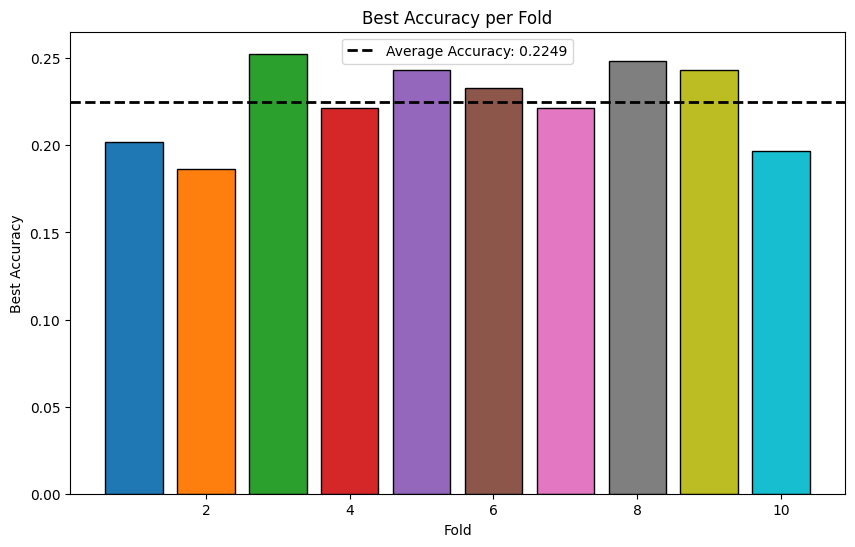

In [117]:
cmap = plt.get_cmap('tab10')
colors = cmap(np.linspace(0, 1, len(best_accuracies)))

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(best_accuracies) + 1), best_accuracies, color=colors, edgecolor='black')
plt.axhline(y=mean_accuracy, color='black', linestyle='--', label=f'Average Accuracy: {mean_accuracy:.4f}', linewidth=2)
plt.xlabel('Fold')
plt.ylabel('Best Accuracy')
plt.title('Best Accuracy per Fold')
plt.legend()
plt.show()

### Accuracies por clase

In [118]:
# Extraer las precisiones por clase y fold
num_classes = 10  # Ajusta según la cantidad de clases que tengas
num_folds = len(folds_performance)
class_accuracies_train = np.zeros((num_folds, num_classes))
class_accuracies_val = np.zeros((num_folds, num_classes))

for i, fold_result in enumerate(folds_performance):
    train_report = fold_result['train_report']
    val_report = fold_result['val_report']
    for class_idx in range(num_classes):
        class_label = str(class_idx)
        if class_label in train_report:
            class_accuracies_train[i, class_idx] = train_report[class_label]['precision']
        if class_label in val_report:
            class_accuracies_val[i, class_idx] = val_report[class_label]['precision']
            
# Calcular el promedio por clase para entrenamiento y validación
mean_class_accuracies_train = np.mean(class_accuracies_train, axis=0)
mean_class_accuracies_val = np.mean(class_accuracies_val, axis=0)

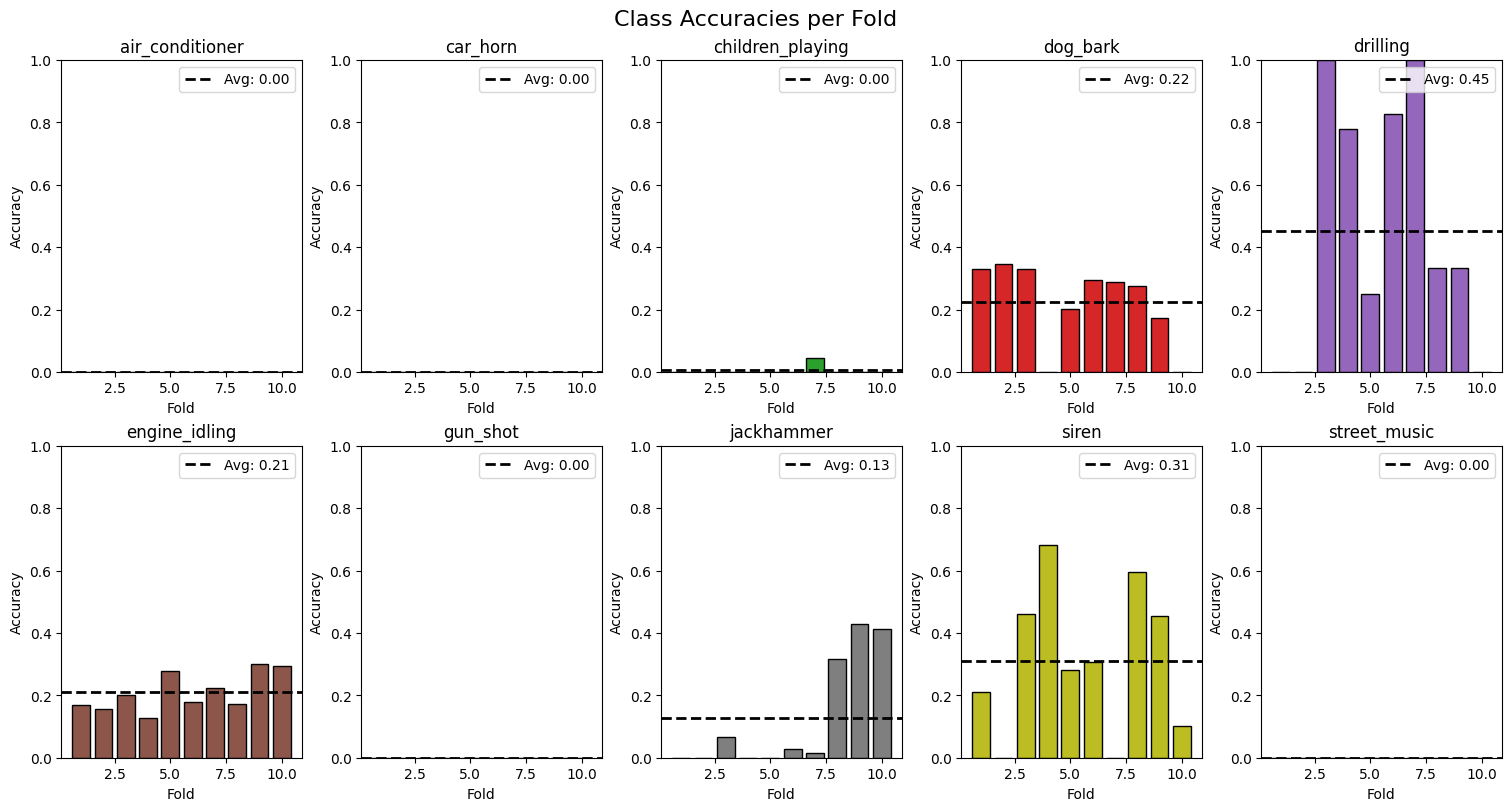

In [119]:
# Definir el layout de los subplots
fig, axs = plt.subplots(2, 5, figsize=(15, 8), constrained_layout=True)
fig.suptitle('Class Accuracies per Fold', fontsize=16)

for class_idx in range(num_classes):
    row = class_idx // 5
    col = class_idx % 5
    ax = axs[row, col]
    
    # Accuracies de cada fold para la clase actual
    accuracies_per_fold = class_accuracies_val[:, class_idx]
    
    # Asignar un color único a todas las barras del subplot (un color distinto por subplot)
    color_option = cmap(class_idx % 10)
    
    # Mismo color para todas las barras en el subplot, pero distinto para cada clase
    ax.bar(range(1, num_folds + 1), accuracies_per_fold, color=color_option, edgecolor='black')
    
    # Línea de promedio
    avg_accuracy = mean_class_accuracies_val[class_idx]
    ax.axhline(y=avg_accuracy, color='black', linestyle='--', label=f'Avg: {avg_accuracy:.2f}', linewidth=2)
    
    # Usar el mapeo para el título de cada clase
    class_name = class_mapping.get(class_idx, f'Class {class_idx}')
    ax.set_title(class_name)
    ax.set_xlabel('Fold')
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0, 1)
    ax.legend()

plt.show()

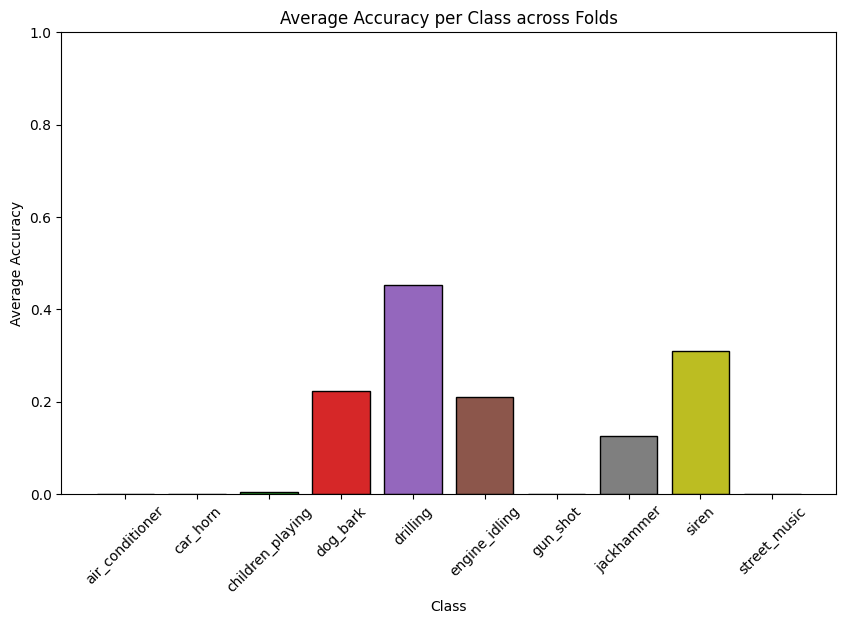

In [120]:
# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(range(num_classes), mean_class_accuracies_val, color=colors, edgecolor='black')
plt.xlabel('Class')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy per Class across Folds')
plt.ylim(0, 1)

# Usar el mapeo para mostrar los nombres de las clases en el eje x
class_labels = [class_mapping.get(i, f'Class {i}') for i in range(num_classes)]
plt.xticks(range(num_classes), class_labels, rotation=45)

plt.show()

### Reportes de clasificacion

In [121]:
print("Validation Classification Report per Fold with Overall Metrics:")

for fold_result in folds_performance:
    print(f"\nFold {fold_result['fold']} - Validation Classification Report:")
    val_report = fold_result['val_report']
    
    # Mostrar métricas por clase solo con el nombre de la clase
    for label, metrics in val_report.items():
        if label.isdigit():  # Solo mostrar métricas por clase
            class_name = class_mapping.get(int(label), "Unknown Class")  # Obtener nombre de la clase
            print(f"{class_name}: Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1-Score: {metrics['f1-score']:.4f}")
    
    # Mostrar métricas generales
    if 'macro avg' in val_report:
        general_metrics = val_report['macro avg']
        print("\nGeneral Metrics (Macro Average):")
        print(f"Precision: {general_metrics['precision']:.4f}, Recall: {general_metrics['recall']:.4f}, F1-Score: {general_metrics['f1-score']:.4f}")
    elif 'weighted avg' in val_report:
        general_metrics = val_report['weighted avg']
        print("\nGeneral Metrics (Weighted Average):")
        print(f"Precision: {general_metrics['precision']:.4f}, Recall: {general_metrics['recall']:.4f}, F1-Score: {general_metrics['f1-score']:.4f}")


Validation Classification Report per Fold with Overall Metrics:

Fold 1 - Validation Classification Report:
air_conditioner: Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
car_horn: Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
children_playing: Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
dog_bark: Precision: 0.3287, Recall: 0.5949, F1-Score: 0.4234
drilling: Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
engine_idling: Precision: 0.1689, Recall: 0.6632, F1-Score: 0.2692
gun_shot: Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
jackhammer: Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
siren: Precision: 0.2103, Recall: 0.5233, F1-Score: 0.3000
street_music: Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000

General Metrics (Macro Average):
Precision: 0.0708, Recall: 0.1781, F1-Score: 0.0993

Fold 2 - Validation Classification Report:
air_conditioner: Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
car_horn: Precision: 0.0000, Recall: 0.0000, F1-Sc

### Historico de Perdidas

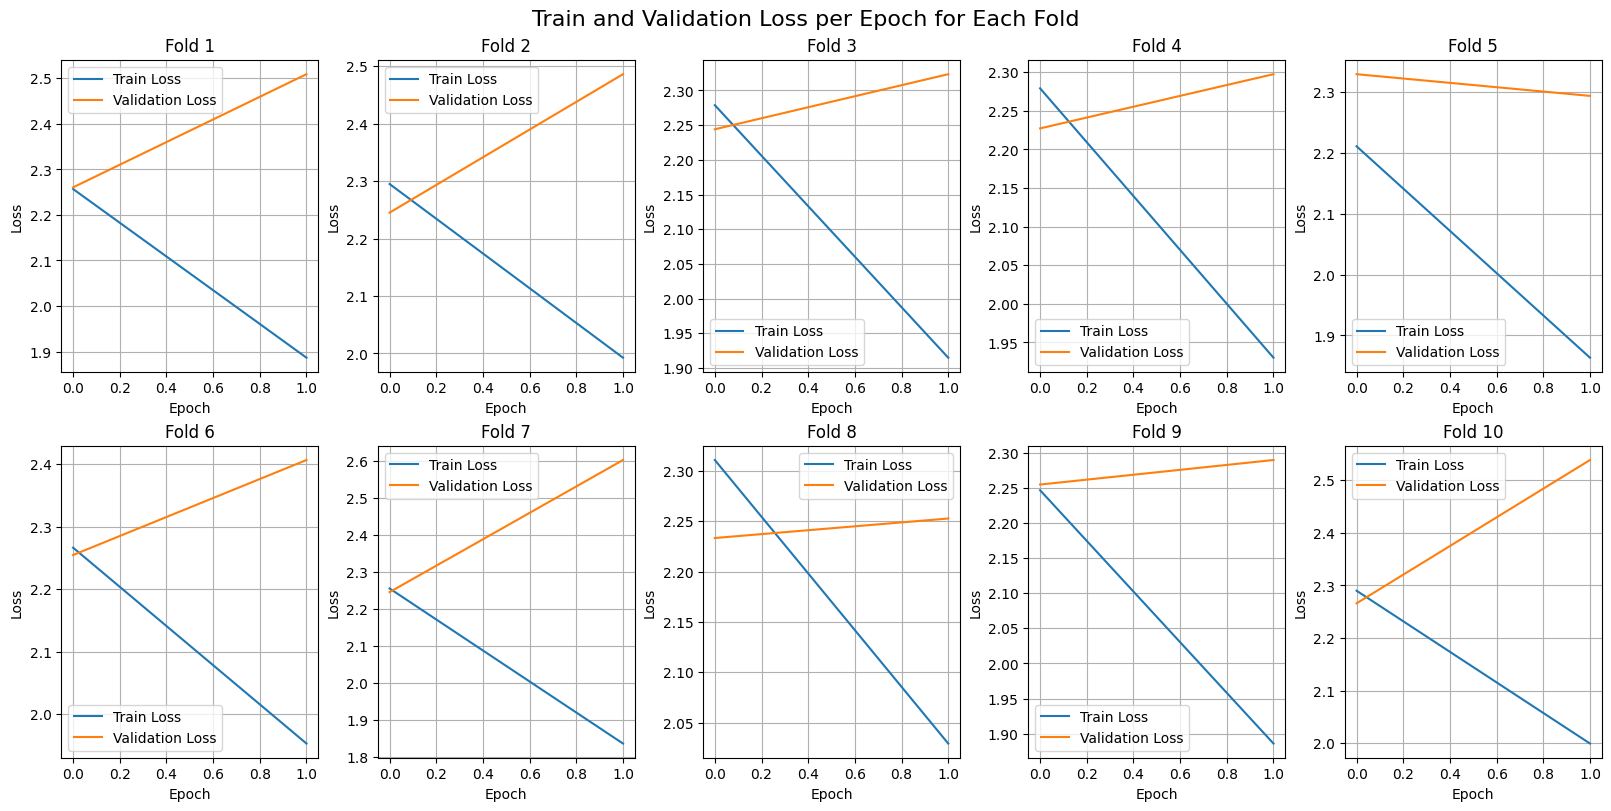

In [122]:
# Definir el número de épocas (asumiendo que todos los folds tienen la misma cantidad de épocas)
num_epochs = len(folds_performance[0]['train_losses'])

# Inicializar arrays para acumular las pérdidas de entrenamiento y validación
avg_train_losses = np.zeros(num_epochs)
avg_val_losses = np.zeros(num_epochs)

# Acumular las pérdidas de cada fold
for fold_result in folds_performance:
    avg_train_losses += np.array(fold_result['train_losses'])
    avg_val_losses += np.array(fold_result['val_losses'])

# Calcular el promedio dividiendo por el número de folds
avg_train_losses /= len(folds_performance)
avg_val_losses /= len(folds_performance)

# Crear los subplots para cada fold
fig, axs = plt.subplots(2, 5, figsize=(16, 8), constrained_layout=True)
fig.suptitle('Train and Validation Loss per Epoch for Each Fold', fontsize=16)

for i, fold_result in enumerate(folds_performance):
    row = i // 5
    col = i % 5
    ax = axs[row, col]
    
    # Extraer pérdidas de entrenamiento y validación
    train_losses = fold_result['train_losses']
    val_losses = fold_result['val_losses']
    
    # Graficar las pérdidas en el subplot correspondiente
    ax.plot(train_losses, label='Train Loss')
    ax.plot(val_losses, label='Validation Loss')
    ax.set_title(f'Fold {fold_result["fold"]}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

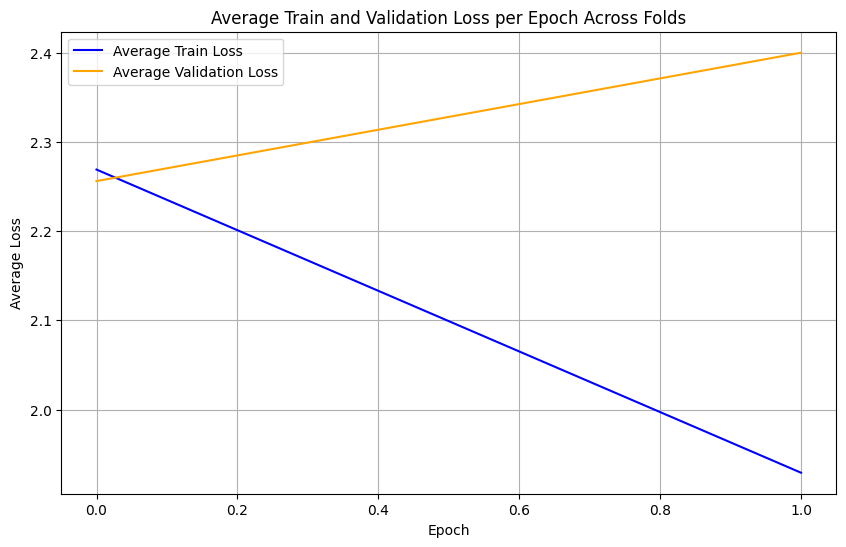

In [123]:
# Gráfico adicional para las pérdidas promedio
plt.figure(figsize=(10, 6))
plt.plot(avg_train_losses, label='Average Train Loss', color='blue')
plt.plot(avg_val_losses, label='Average Validation Loss', color='orange')
plt.title('Average Train and Validation Loss per Epoch Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)
plt.show()

### Historico de Precisiones

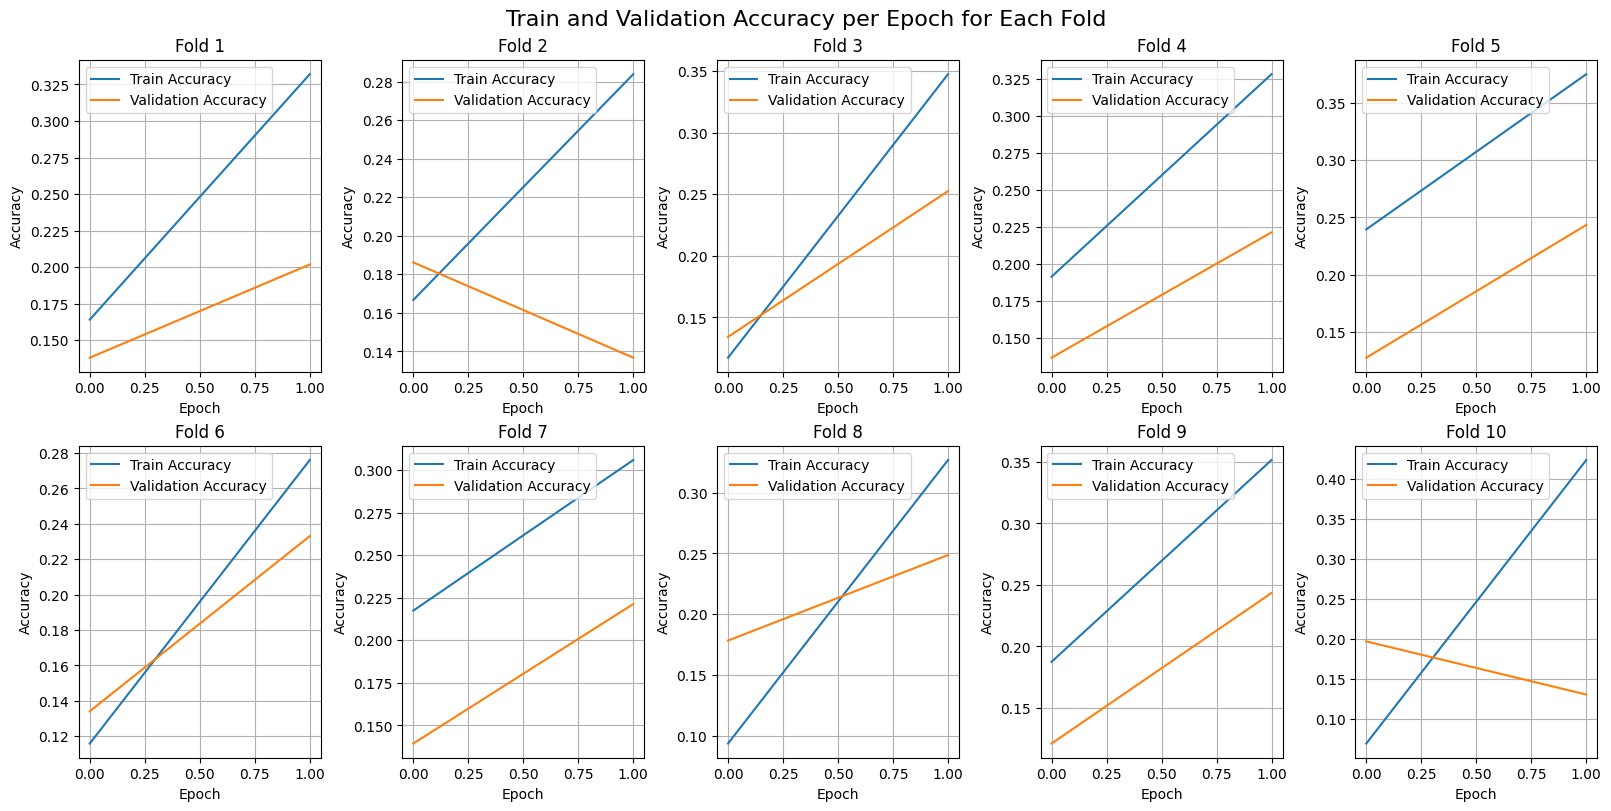

In [124]:
# Definir el número de épocas (asumiendo que todos los folds tienen la misma cantidad de épocas)
num_epochs = len(folds_performance[0]['train_accuracies'])

# Inicializar arrays para acumular las precisiones de entrenamiento y validación
avg_train_accuracies = np.zeros(num_epochs)
avg_val_accuracies = np.zeros(num_epochs)

# Acumular las precisiones de cada fold
for fold_result in folds_performance:
    avg_train_accuracies += np.array(fold_result['train_accuracies'])
    avg_val_accuracies += np.array(fold_result['val_accuracies'])

# Calcular el promedio dividiendo por el número de folds
avg_train_accuracies /= len(folds_performance)
avg_val_accuracies /= len(folds_performance)

# Crear los subplots para cada fold
fig, axs = plt.subplots(2, 5, figsize=(16, 8), constrained_layout=True)
fig.suptitle('Train and Validation Accuracy per Epoch for Each Fold', fontsize=16)

for i, fold_result in enumerate(folds_performance):
    row = i // 5
    col = i % 5
    ax = axs[row, col]
    
    # Extraer precisiones de entrenamiento y validación
    train_accuracies = fold_result['train_accuracies']
    val_accuracies = fold_result['val_accuracies']
    
    # Graficar las precisiones en el subplot correspondiente
    ax.plot(train_accuracies, label='Train Accuracy')
    ax.plot(val_accuracies, label='Validation Accuracy')
    ax.set_title(f'Fold {fold_result["fold"]}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True)

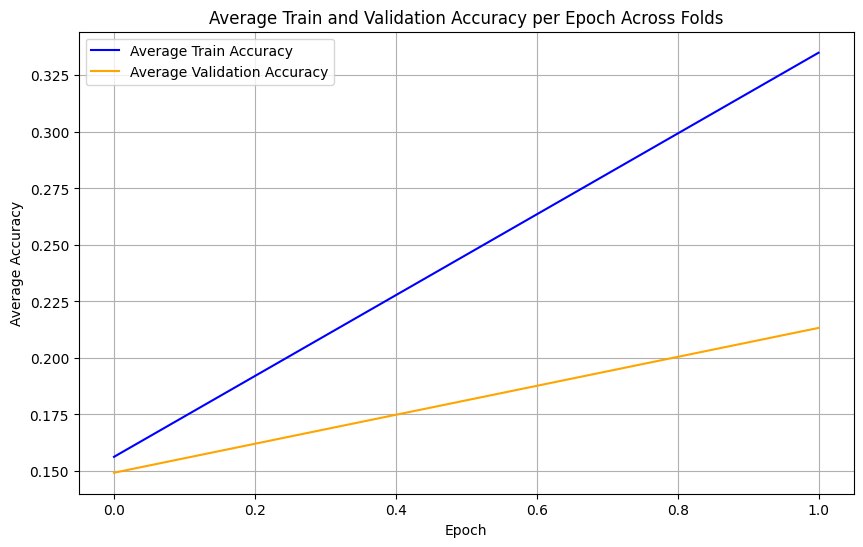

In [125]:
# Gráfico adicional para las precisiones promedio
plt.figure(figsize=(10, 6))
plt.plot(avg_train_accuracies, label='Average Train Accuracy', color='blue')
plt.plot(avg_val_accuracies, label='Average Validation Accuracy', color='orange')
plt.title('Average Train and Validation Accuracy per Epoch Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Matrices de Confusion

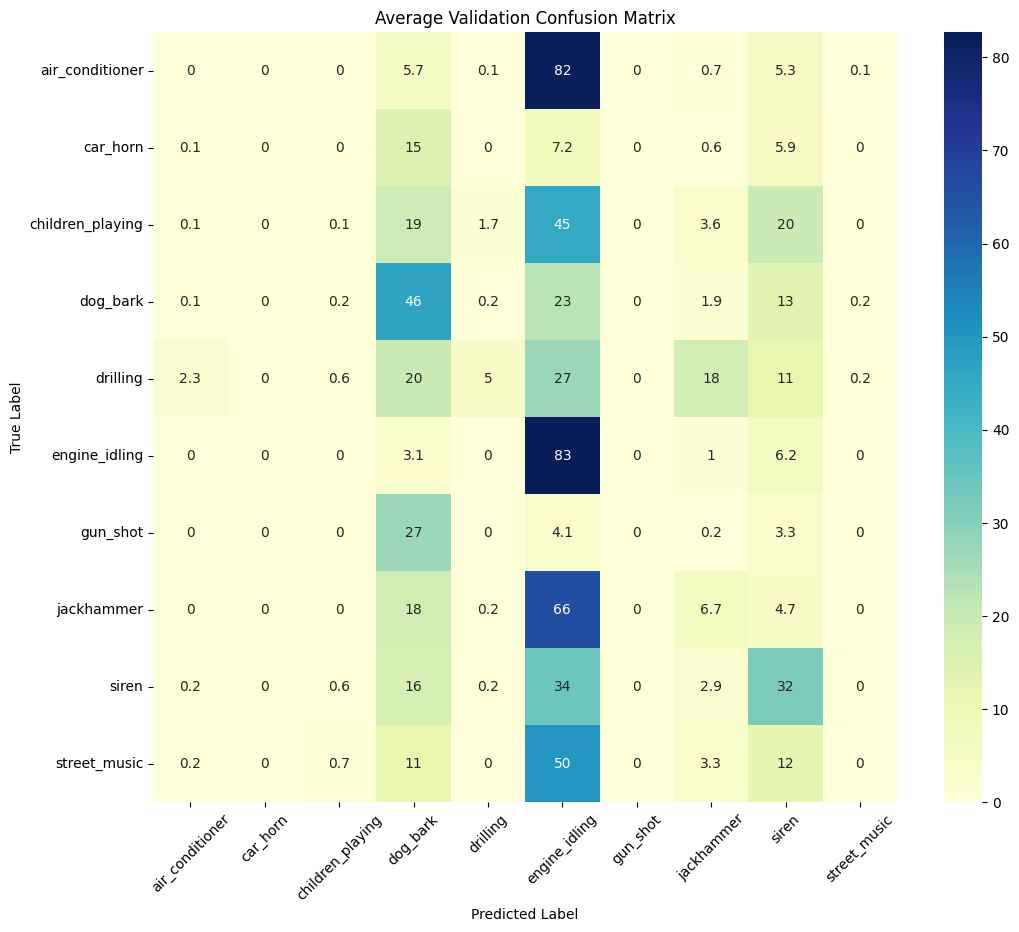

In [128]:
# Inicializar una matriz para acumular las matrices de confusión de validación
num_classes = folds_performance[0]['val_matrix'].shape[0]
avg_conf_matrix = np.zeros((num_classes, num_classes), dtype=float)

# Acumular las matrices de confusión de cada fold
for fold_result in folds_performance:
    avg_conf_matrix += fold_result['val_matrix']

# Calcular el promedio dividiendo por el número de folds
avg_conf_matrix /= len(folds_performance)

# Obtener las etiquetas de clase usando el mapeo
class_labels = [class_mapping[i] for i in range(num_classes)]

# Graficar la matriz de confusión promedio
plt.figure(figsize=(12, 10))
sns.heatmap(avg_conf_matrix, annot=True, cmap="YlGnBu", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Average Validation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.xticks(rotation=45)
plt.ylabel("True Label")
plt.show()
